# PRE

## CONNECT DRIVE

In [ ]:
from google.colab import drive

drive.mount("/gdrive")
%cd /gdrive/My Drive/[2024-2025] AN2DL/Homework 2

Mounted at /gdrive
/gdrive/My Drive/[2024-2025] AN2DL/Homework 2


## IMPORT LIBRARIES

In [ ]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import os
import math
from PIL import Image
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.17.1


## LOAD DATA

In [ ]:
data = np.load("mars_for_students.npz")

training_set = data["training_set"]
X_train = training_set[:, 0]
y_train = training_set[:, 1]

X_test = data["test_set"]

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape: (2615, 64, 128)
Training y shape: (2615, 64, 128)
Test X shape: (10022, 64, 128)


In [ ]:

def convert_to_3_channels(image_array):
  """Converts a grayscale image to a 3-channel RGB image.

  Args:
    image_array: A NumPy array representing a grayscale image.

  Returns:
    A NumPy array representing the 3-channel RGB image.
  """
  if len(image_array.shape) == 2:
    # If the image is grayscale (single channel), stack it three times to create an RGB image
      return np.stack((image_array,)*3, axis=-1)
  elif len(image_array.shape) == 3 and image_array.shape[2] == 3:
    # If the image already has 3 channels, return as is
      return image_array
  else:
      # Handle cases where the image has an unsupported number of channels
      print(f"Warning: Unexpected number of image channels. Original shape: {image_array.shape}")
      # You can choose an appropriate action:
      # 1. Return the original image:
      return image_array
      # 2. Raise an error:
      # raise ValueError("Unsupported number of image channels.")
      # 3. Convert to grayscale and then stack:
      # grayscale_image = np.mean(image_array, axis=-1, keepdims=True)
      # return np.concatenate((grayscale_image,) * 3, axis=-1)

# Example usage: Assuming X_train contains images
X_train_3_channels = np.array([convert_to_3_channels(img) for img in X_train])
X_test_3_channels = np.array([convert_to_3_channels(img) for img in X_test])

print(f"Training X shape (3 channels): {X_train_3_channels.shape}")
print(f"Test X shape (3 channels): {X_test_3_channels.shape}")

Training X shape (3 channels): (2615, 64, 128, 3)
Test X shape (3 channels): (10022, 64, 128, 3)


In [ ]:
category_map ={
    0: 0, #Background
    1: 1, #Soil
    2: 2, #Bedrock
    3: 3, #Sand
    4: 4, #Big Rock
}

# CHECK DATASET

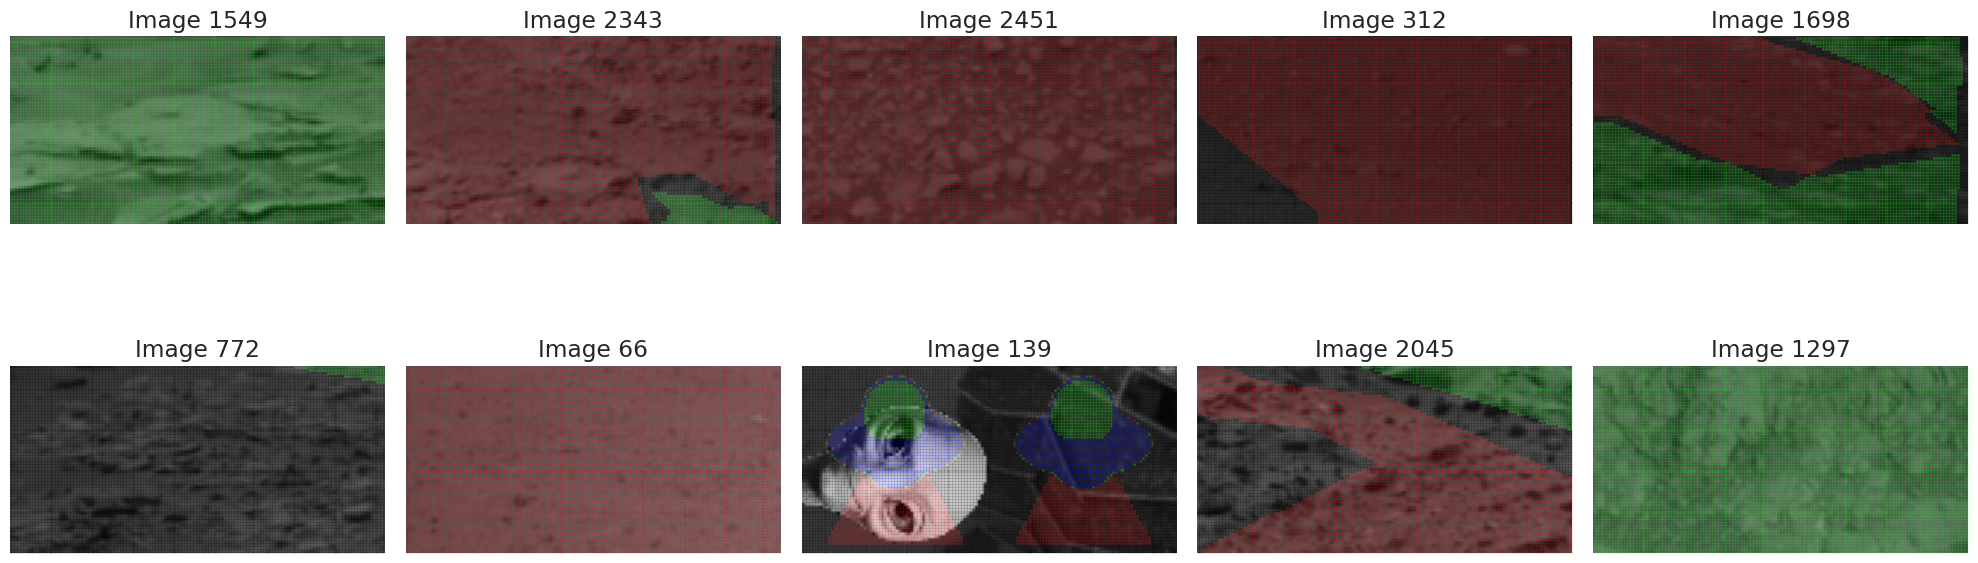

In [ ]:

import matplotlib.pyplot as plt

# Define a colormap for the 5 labels
colors = {
    0: [0, 0, 0, 0.2],  # Transparent Black for Background
    1: [1, 0, 0, 0.2],  # Red for Soil
    2: [0, 1, 0, 0.2],  # Green for Bedrock
    3: [0, 0, 1, 0.2],  # Blue for Sand
    4: [1, 1, 0, 0.2],  # Yellow for Big Rock
}

# Select random indices
num_images_to_display = 10
random_indices = np.random.choice(len(X_train), num_images_to_display, replace=False)


fig, axes = plt.subplots(2, 5, figsize=(20, 8))

for i, index in enumerate(random_indices):
    image = X_train_3_channels[index]/255
    label = y_train[index]

    row = i // 5
    col = i % 5
    ax = axes[row, col]


    ax.imshow(image)

    # Overlay the labels with colors
    for label_value in np.unique(label):
      if label_value in colors:
          colored_mask = np.where(label == label_value)
          ax.scatter(colored_mask[1], colored_mask[0], color=colors[label_value][:3], alpha=colors[label_value][3], s=1)

    ax.set_title(f"Image {index}")
    ax.axis('off')

plt.tight_layout()
plt.show()

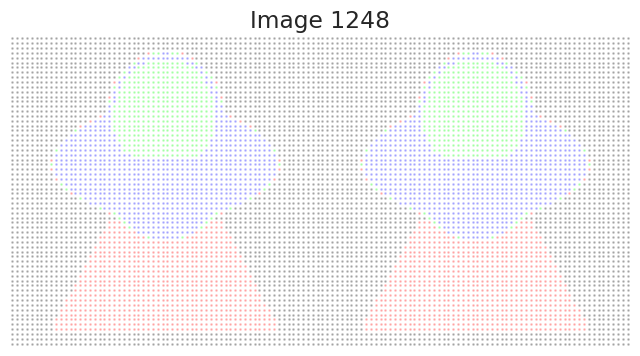

In [ ]:

# Assuming X_train_3_channels and y_train are defined as in the provided code.
# Also assuming you want to visualize image with index 1248.

image_index = 1248

if 0 <= image_index < len(X_train_3_channels):
    image = X_train_3_channels[image_index]
    label = y_train[image_index]

    plt.figure(figsize=(8, 6))
    plt.imshow(image)

    # Overlay the labels with colors (as in your original code)
    for label_value in np.unique(label):
      if label_value in colors:
          colored_mask = np.where(label == label_value)
          plt.scatter(colored_mask[1], colored_mask[0], color=colors[label_value][:3], alpha=colors[label_value][3], s=1)

    plt.title(f"Image {image_index}")
    plt.axis('off')
    plt.show()

else:
    print(f"Error: Image index {image_index} is out of range.")

In [ ]:

# Create a hash table to store the labels and their indices
label_hash_table = {}
for i, label in enumerate(y_train):
    label_tuple = tuple(label.flatten())  # Convert label array to a tuple for hashing
    if label_tuple not in label_hash_table:
        label_hash_table[label_tuple] = []
    label_hash_table[label_tuple].append(i)

# Get the label of the image at index 1248
target_label = y_train[1248]
target_label_tuple = tuple(target_label.flatten())

# Find indices with matching labels using the hash table
matching_indices = label_hash_table.get(target_label_tuple, [])

# Print the indices
print("Indices of images with the same labels as image 1248:")
matching_indices

Indices of images with the same labels as image 1248:


[62,
 79,
 125,
 139,
 142,
 147,
 152,
 156,
 170,
 210,
 217,
 266,
 289,
 299,
 313,
 339,
 348,
 365,
 412,
 417,
 426,
 450,
 461,
 536,
 552,
 669,
 675,
 741,
 744,
 747,
 799,
 802,
 808,
 820,
 821,
 849,
 863,
 890,
 909,
 942,
 971,
 1005,
 1057,
 1079,
 1082,
 1092,
 1095,
 1106,
 1119,
 1125,
 1177,
 1194,
 1224,
 1247,
 1248,
 1258,
 1261,
 1262,
 1306,
 1324,
 1365,
 1370,
 1443,
 1449,
 1508,
 1509,
 1519,
 1551,
 1584,
 1588,
 1628,
 1637,
 1693,
 1736,
 1767,
 1768,
 1782,
 1813,
 1816,
 1834,
 1889,
 1925,
 1942,
 1975,
 1979,
 2000,
 2002,
 2086,
 2096,
 2110,
 2111,
 2151,
 2161,
 2222,
 2235,
 2239,
 2242,
 2301,
 2307,
 2350,
 2361,
 2365,
 2372,
 2414,
 2453,
 2522,
 2535,
 2561,
 2609,
 2614]

First 5 matching indices: [62, 79, 125, 139, 142]
Number of matching indices: 110


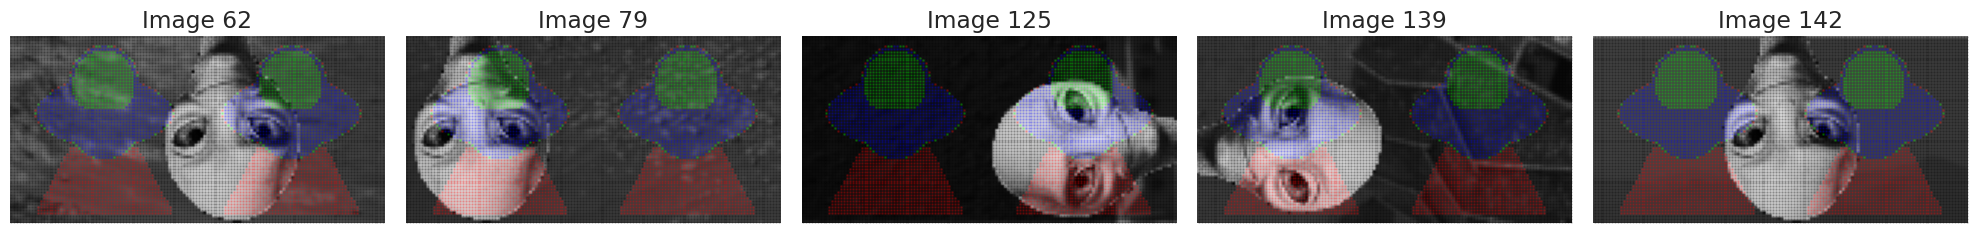

In [ ]:

# Print some examples from matching_indices
print("First 5 matching indices:", matching_indices[:5])
print("Number of matching indices:", len(matching_indices))

# If you want to visualize some of the matching images:
num_images_to_display = min(5, len(matching_indices))  # Display up to 5 images or fewer if available
fig, axes = plt.subplots(1, num_images_to_display, figsize=(20, 4))

for i in range(num_images_to_display):
    image_index = matching_indices[i]
    image = X_train_3_channels[image_index] / 255
    label = y_train[image_index]

    ax = axes[i]
    ax.imshow(image)

    for label_value in np.unique(label):
        if label_value in colors:
            colored_mask = np.where(label == label_value)
            ax.scatter(colored_mask[1], colored_mask[0], color=colors[label_value][:3], alpha=colors[label_value][3], s=1)

    ax.set_title(f"Image {image_index}")
    ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:

# Remove the example images from matching indices
# Assuming matching_indices and X_train_3_channels, y_train are defined as in your previous code

# Create a boolean mask to exclude the indices of example images
indices_to_exclude = matching_indices
mask = np.ones(len(X_train_3_channels), dtype=bool)
mask[indices_to_exclude] = False

# Apply the mask to filter out the examples from X_train_3_channels and y_train
X_train_filtered = X_train_3_channels[mask]
y_train_filtered = y_train[mask]

# Print the shapes of the filtered arrays to verify
print("Shape of X_train_filtered:", X_train_filtered.shape)
print("Shape of y_train_filtered:", y_train_filtered.shape)

# Now X_train_filtered and y_train_filtered contain the data without the examples

Shape of X_train_filtered: (2505, 64, 128, 3)
Shape of y_train_filtered: (2505, 64, 128)


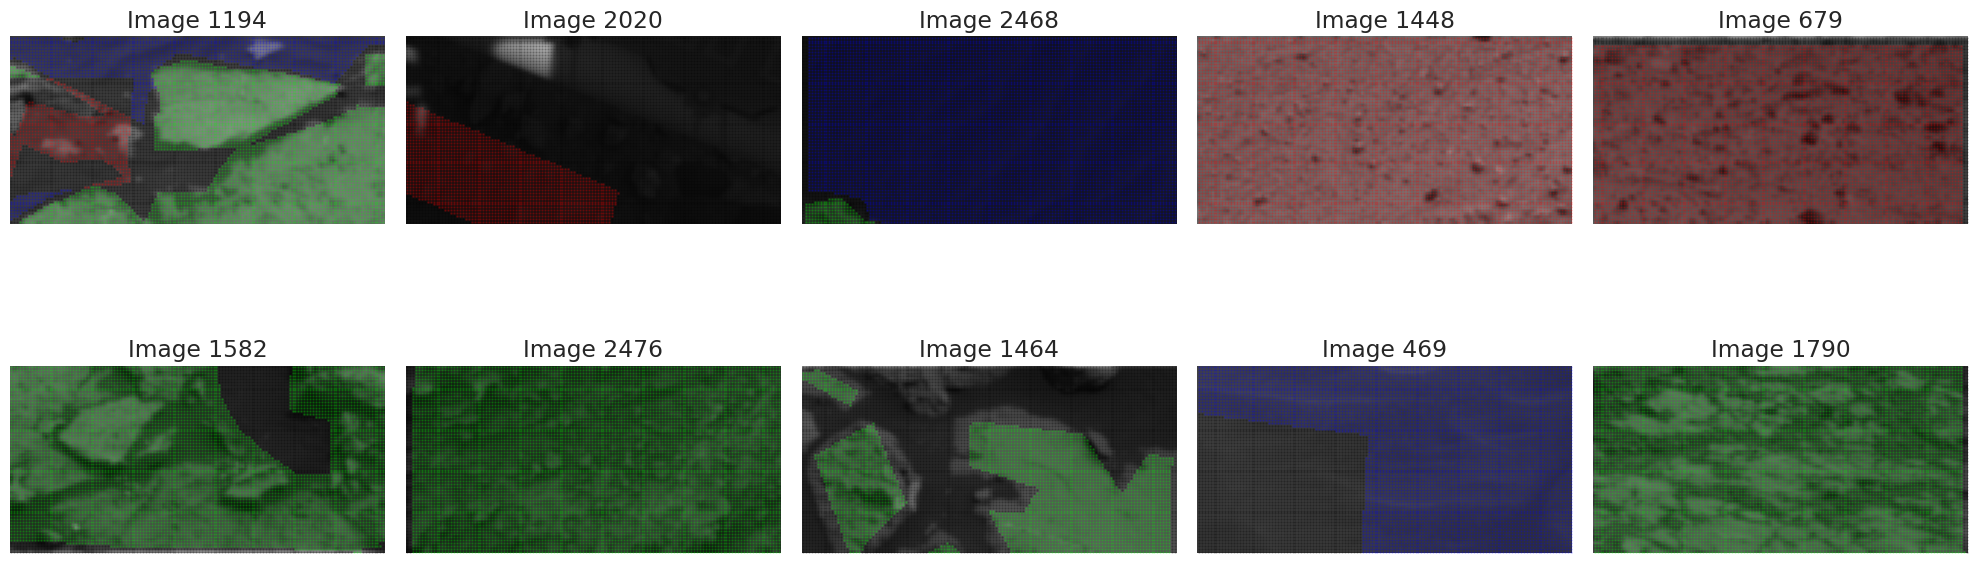

In [ ]:

import matplotlib.pyplot as plt

# Define a colormap for the 5 labels
colors = {
    0: [0, 0, 0, 0.2],  # Transparent Black for Background
    1: [1, 0, 0, 0.2],  # Red for Soil
    2: [0, 1, 0, 0.2],  # Green for Bedrock
    3: [0, 0, 1, 0.2],  # Blue for Sand
    4: [1, 1, 0, 0.2],  # Yellow for Big Rock
}

# Select random indices
num_images_to_display = 10
random_indices = np.random.choice(len(X_train_filtered), num_images_to_display, replace=False)


fig, axes = plt.subplots(2, 5, figsize=(20, 8))

for i, index in enumerate(random_indices):
    image = X_train_filtered[index]/255
    label = y_train_filtered[index]

    row = i // 5
    col = i % 5
    ax = axes[row, col]


    ax.imshow(image)

    # Overlay the labels with colors
    for label_value in np.unique(label):
      if label_value in colors:
          colored_mask = np.where(label == label_value)
          ax.scatter(colored_mask[1], colored_mask[0], color=colors[label_value][:3], alpha=colors[label_value][3], s=1)

    ax.set_title(f"Image {index}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:

np.savez_compressed("no_alien_dataset_3colors.npz",
                    train_images_set=X_train_filtered,
                    train_labels_set=y_train_filtered,
                    test_set=X_test_3_channels)